In [1]:
# | eval: false
from datasets import load_dataset
import pandas as pd
import polars as pl
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from pathlib import Path

sns.set_theme("notebook")

# Raw & Instruct Datasets Analyses

In [2]:
# | eval: false
raw_ds = pl.scan_parquet(source="../../data/datasets/pl/raw/*")
raw_ds.columns

['_id',
 'signature',
 'date',
 'publicationDate',
 'lastUpdate',
 'courtId',
 'departmentId',
 'type',
 'excerpt',
 'content',
 'chairman',
 'decision',
 'judges',
 'legalBases',
 'publisher',
 'recorder',
 'references',
 'reviser',
 'themePhrases',
 'num_pages',
 'text',
 'vol_number',
 'vol_type',
 'court_name',
 'department_name',
 'text_legal_bases',
 'thesis']

Dataset description
----

The dataset consists of Polish Court judgements available at https://orzeczenia.ms.gov.pl/, containing full content of the judgements along with metadata sourced from official API and extracted from the judgement contents. Dataset was build in 3 stages, namely:
1. Data acquisition
2. Data preprocessing and extraction
3. Instruction dataset generation
Following, we provide detailed description of each stage.

### 1. Data acquisition

First, we leveraged the official API to download all available judgements along with their metadata. The download procedure resulted in **414 148** documents, containing documents published no later than `2024-03-06`. Among all documents, **408 423** (98.62%) contain content of the judgement, hence are usable for the further processing and final dataset. 

Acquired data consists of the following features:

| Feature name    | Feature description                                                                | Type                                  |
|-----------------|------------------------------------------------------------------------------------|---------------------------------------|
| _id             | unique identifier of the judgement                                                 | `string`                              |
| signature       | signature of judgement (unique within court)                                       | `string`                              |
| date            | date of judgement                                                                  | `datetime` (ISO format with timezone) |
| publicationDate | date of judgement publication                                                      | `datetime` (ISO format with timezone) |
| lastUpdate      | date of last update of judgement                                                   | `datetime` (ISO format with timezone) |
| courtId         | system unique identifier of the court                                              | `int`                                 |
| departmentId    | system unique identifier of the court's department                                 | `int`                                 |
| type            | type of the judgement (one of )                                                    | `string`                              |
| excerpt         | First 500 characters of the judgement                                              | `string` or  `None`                            |
| content         | Full content of judgement as XML file                                              | `string` or `None`                              |
| chairman        | chairman judge name                                                                | `string`                              |
| decision        | decision                                                                           | `string` or `None`                       |
| judges          | list of judge names participating in the judgement                                 | `list[string]`                        |
| legalBases      | legal acts which are bases for the judgement (with references to online repository | `list[dict[str, str]]`                |



### Data preprocessing
For further processing, we used only documents containing judgement content. During preprocessing, we extracted additional metadata from the content XML, and then converted XML to plain text. XML files contain tagged metadata which could be readily extracted with arbitrary XML parser. In particular, we were able to extend metadata fields described above by extracting following ones from XML:

| Feature name     | Feature description                     | Type                   |
|------------------|-----------------------------------------|------------------------|
| text_legal_bases | legal bases names found in text         | `list[dict[str, str]]` |
| num_pages        | numer of pages of the original document | `int`                  |
| vol_number       | volume number                           | `int`                  |
| vol_type         | volume type                             | `string`               |
| text             | plain text extracted from content XML   | `string`               |


In addition we mapped `courtId` and `departmentId` fields according to mapping acquired from https://orzeczenia.wroclaw.sa.gov.pl/indices. During this procedure we identified that some judgements have incorrect court or department identifiers, and decided to leave their names as empty values. In the aftermath, mapping resulted in the additional two columns:
| Feature name    | Feature description         | Type     |
|-----------------|-----------------------------|----------|
| court_name      | full name of the court      | `string` |
| department_name | full name of the court's department | `string` |


All acquired and preprocessed data is stored in `MongoDB` dataset, and for further processing we performed dataset dump. The dumped dataset was used to create intruction dataset for information extraction. Also, we publish raw dataset dump called `pl-court-judgments-raw`.

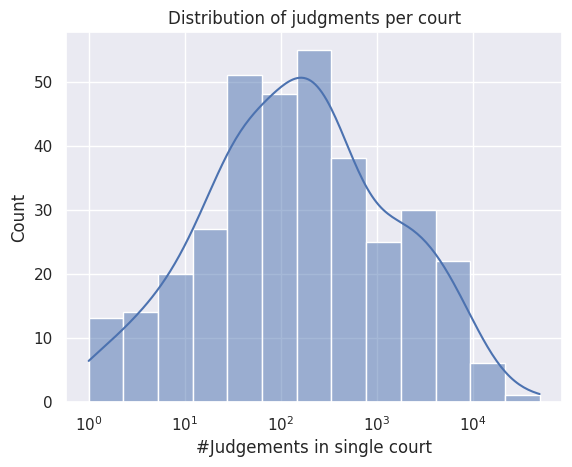

In [3]:
# | eval: false
court_distribution = raw_ds.drop_nulls(subset="court_name").select("court_name").group_by("court_name").len().sort("len", descending=True).collect().to_pandas()
ax = sns.histplot(data=court_distribution, x="len", log_scale=True, kde=True)
ax.set(title="Distribution of judgments per court", xlabel="#Judgements in single court", ylabel="Count")
plt.show()

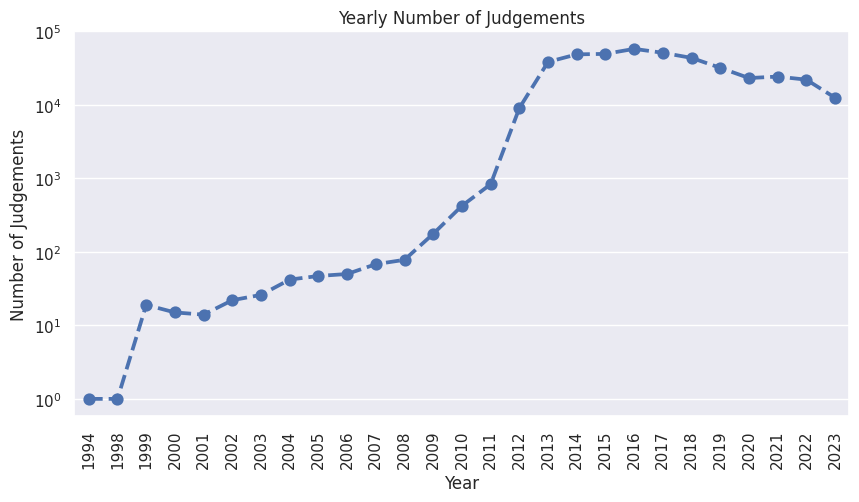

In [4]:
# | eval: false
judgements_per_year = raw_ds.select("date").collect()["date"].str.split(" ").list.get(0).str.to_date().dt.year().value_counts().sort("date").to_pandas()
judgements_per_year = judgements_per_year[judgements_per_year["date"] < 2024]

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.pointplot(data=judgements_per_year, x="date", y="count", linestyles="--", ax=ax)
ax.set(xlabel="Year", ylabel="Number of Judgements", title="Yearly Number of Judgements", yscale="log")
plt.xticks(rotation=90)
plt.show()

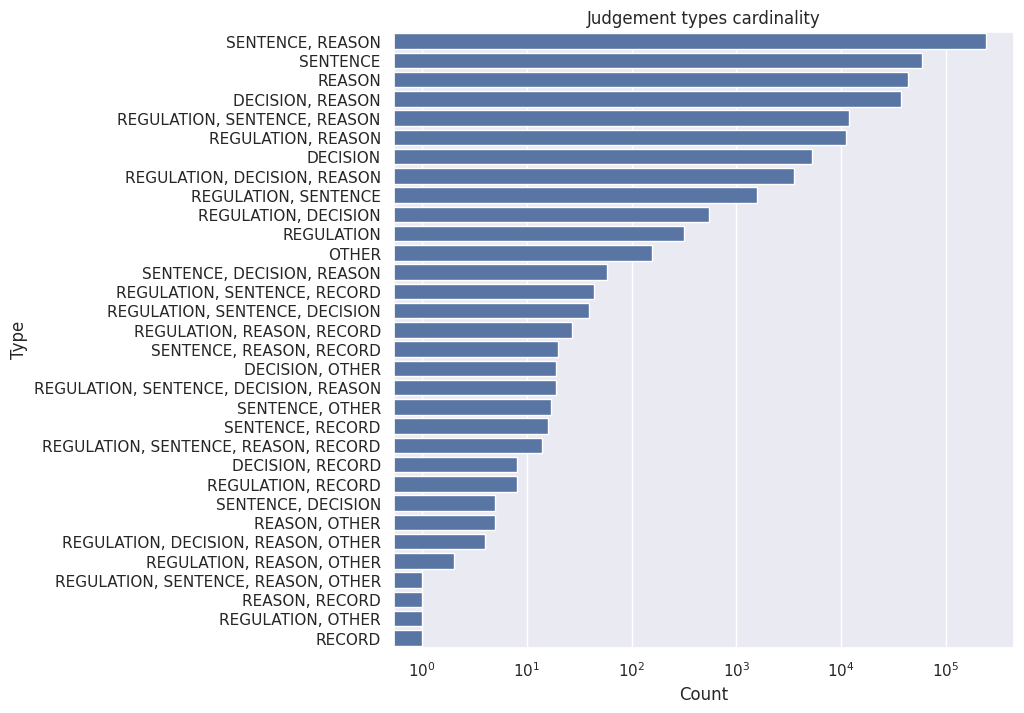

In [5]:
# | eval: false
types = raw_ds.fill_null(value="<null>").select("type").group_by("type").len().sort("len", descending=True).collect().to_pandas()

_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = sns.barplot(data=types, x="len", y="type", errorbar=None, ax=ax)
ax.set(xlabel="Count", ylabel="Type", title="Judgement types cardinality", xscale="log")
plt.show()

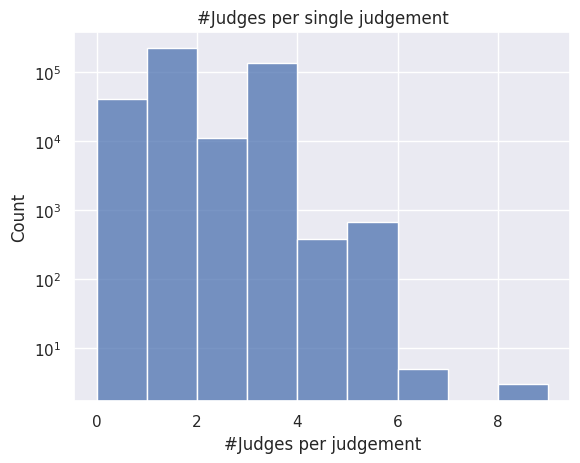

In [6]:
# | eval: false
num_judges = raw_ds.with_columns([pl.col("judges").list.len().alias("num_judges")]).select("num_judges").sort("num_judges").collect().to_pandas()
ax = sns.histplot(data=num_judges, x="num_judges", bins=num_judges["num_judges"].nunique())
ax.set(xlabel="#Judges per judgement", ylabel="Count", yscale="log", title="#Judges per single judgement")
plt.show()

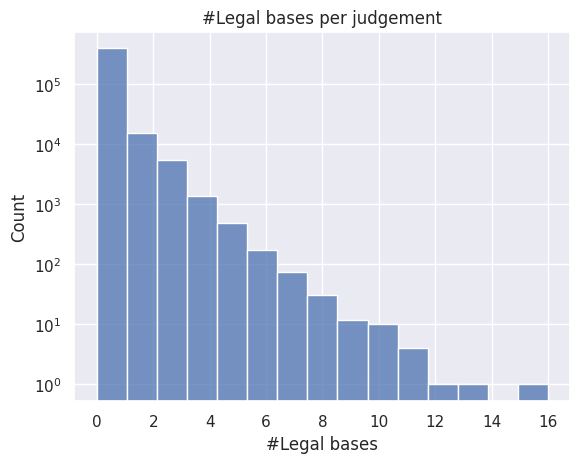

In [7]:
# | eval: false
num_lb = raw_ds.with_columns([pl.col("legalBases").list.len().alias("num_lb")]).select("num_lb").sort("num_lb").collect().to_pandas()
ax = sns.histplot(data=num_lb, x="num_lb", bins=num_lb["num_lb"].nunique())
ax.set(xlabel="#Legal bases", ylabel="Count", yscale="log", title="#Legal bases per judgement")
plt.show()

In [8]:
# | eval: false
raw_text_ds = load_dataset("parquet", data_dir="../../data/datasets/pl/raw/", columns=["_id", "text"])
raw_text_ds = raw_text_ds.filter(lambda x: x["text"] is not None)

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

In [9]:
# | eval: false
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

def tokenize(batch: dict[str, list]) -> list[int]: 
    tokenized = tokenizer(batch["text"], add_special_tokens=False, return_attention_mask=False, return_token_type_ids=False, return_length=True)
    return {"length": tokenized["length"]}

raw_text_ds = raw_text_ds.map(tokenize, batched=True, batch_size=16, remove_columns=["text"], num_proc=20)
raw_text_ds

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DatasetDict({
    train: Dataset({
        features: ['_id', 'length'],
        num_rows: 408423
    })
})

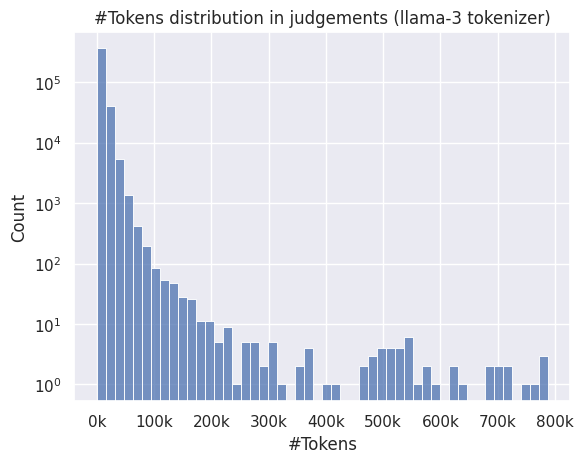

In [10]:
# | eval: false
judgement_len = raw_text_ds["train"].to_pandas()

ax = sns.histplot(data=judgement_len, x="length", bins=50)
ax.set(xlabel="#Tokens", ylabel="Count", title="#Tokens distribution in judgements (llama-3 tokenizer)", yscale="log")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))
plt.show()

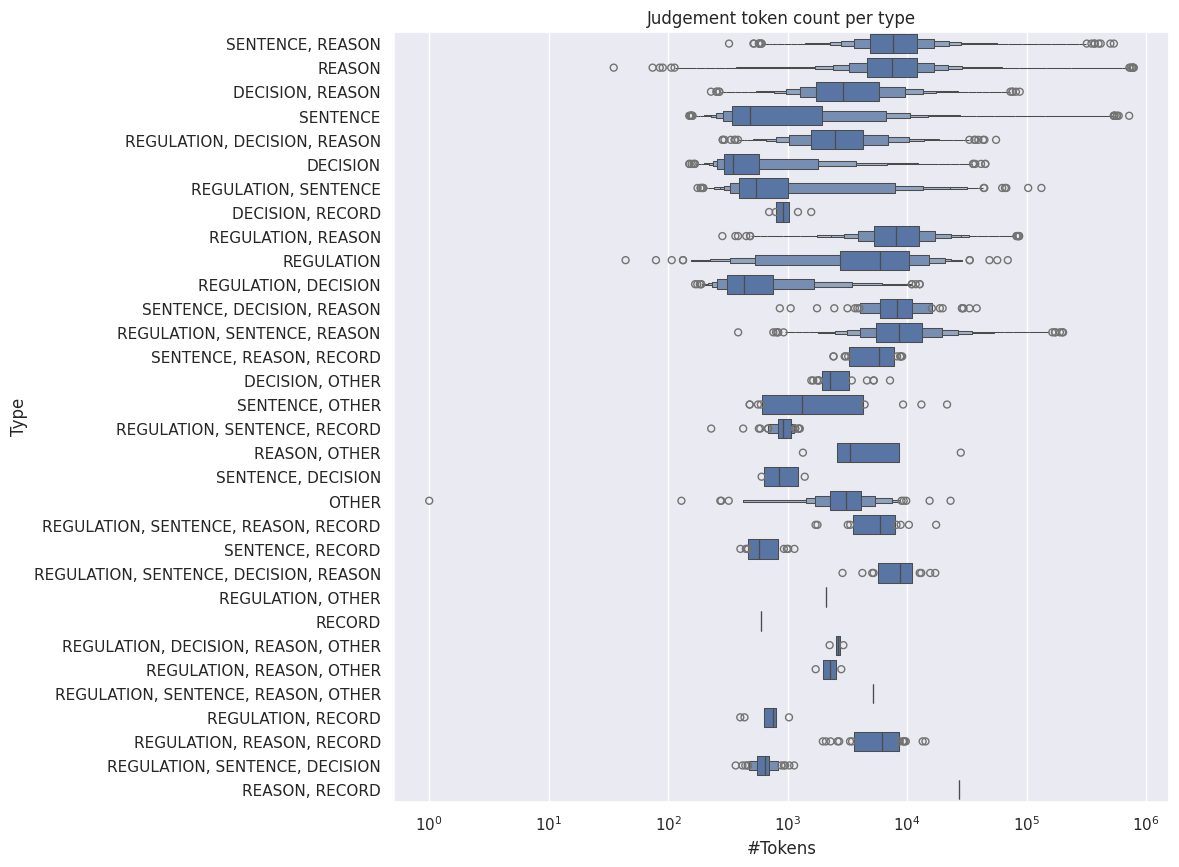

In [11]:
# | eval: false
per_type_tokens = raw_ds.fill_null(value="<null>").select(["_id", "type"]).collect().to_pandas().set_index("_id").join(judgement_len.set_index("_id"))

_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.boxenplot(data=per_type_tokens, y="type", x="length")
ax.set(xscale="log", title="Judgement token count per type", xlabel="#Tokens", ylabel="Type")
plt.show()

### Instruction dataset creation


In order to verify and fine-tune Large Language Models in task of automated information extraction from judgements, we built instruction dataset as follows. First, we identified information from metadata which is contained in text of the judgement. Therefore, the following fields were selected for extraction as targets:
* `date`
* `judges`
* `recorder`
* `signature`
* `court_name`
* `department_name`
* `legal_bases`

In order to ensure high quality of the dataset, we performed filtering procedure, as described below.

#### Data filtering
1. Removal of judgements with missing values in targets - if any of the target field has missing value, entire judgement is discarded (information might still be contained in judgement text, and in such case the targets would be incorrect)
2. Cleaning `judges` field - in some examples, names of judges were concatenated into single name instead of being list of names, so we split them based on conjunction
3. Removing examples wherein targets are not in text - due to inherent errors in acquired data, some targets might be mistyped, hence we filter them out

Data cleaning removes 173297 examples, and dataset consists of 240851.

#### Generating instructions
After cleaning we generate instructions for information extraction. Specifically, we define same prompt for each document, as follows:

```text
You are extracting information from the Polish court judgments.
Extract specified values strictly from the provided judgement. If information is not provided in the judgement, leave the field with null value.
Please return the response in the identical YAML format:
'''yaml
court_name: "<nazwa sądu, string containing the full name of the court>"
date: <data, date in format YYYY-MM-DD>
department_name: "<nazwa wydziału, string containing the full name of the court's department>"
judges: "<sędziowie, list of judge full names>"
legal_bases: <podstawy prawne, list of strings containing legal bases (legal regulations)>
recorder: <protokolant, string containing the name of the recorder>
signature: <sygnatura, string contraining the signature of the judgment>
'''
=====
{context}
======
```
where `{context}` is replaced by text of each judgement. We highlight that judements are in Polish, hence to foster model responding in Polish, we provide name Polish names of the field in the prompt.

# Instruction dataset
The dataset consists of 4 fields:

* `_id` - unique identifier of the judgement
* `prompt` - prompt containing instruction with `{context}` variable which should be substituted with `context`
* `context` - judgement content (plain text)
* `output` - label, expected output of the model

We divided dataset into `train` and `test` split with the following sizes:
| Split | size   | fraction |
|-------|--------|----------|
| train | 238851 | 99.17    |
| test  | 2000   |  0.83    |

In [12]:
# | eval: false
instruct_ds = load_dataset("JuDDGES/pl-court-instruct")
instruct_ds

DatasetDict({
    train: Dataset({
        features: ['_id', 'prompt', 'context', 'output'],
        num_rows: 238851
    })
    test: Dataset({
        features: ['_id', 'prompt', 'context', 'output'],
        num_rows: 2000
    })
})

### Split sizes

In [13]:
# | eval: false
df = pd.DataFrame([{"Split":k, "#": len(v)} for k, v in instruct_ds.items()])
df["%"] = df["#"] / df["#"].sum() * 100
df.round(2)

,Split,#,%
0,train,238851,99.17
1,test,2000,0.83


## Analysis

In [14]:
# | eval: false
from torch import le


def tokenize_and_comp_length_instruct_ds(batch: dict[str, list]) -> dict[str, list]:
    tokenized_ctx = tokenizer(batch["context"], add_special_tokens=False, return_attention_mask=False, return_token_type_ids=False, return_length=True)
    tokenized_out = tokenizer(batch["output"], add_special_tokens=False, return_attention_mask=False, return_token_type_ids=False, return_length=True)

    return {"context_num_tokens": tokenized_ctx["length"], "output_num_tokens": tokenized_out["length"]}

instruct_ds_tok = instruct_ds.map(tokenize_and_comp_length_instruct_ds, batched=True, batch_size=32, remove_columns=["prompt", "context", "output"], num_proc=20)
instruct_ds_tok = pd.concat([instruct_ds_tok["train"].to_pandas(), instruct_ds_tok["test"].to_pandas()], axis=0, keys=["train", "test"]).reset_index(level=0).rename(columns={"level_0": "split"})
instruct_ds_tok.head()

,split,_id,context_num_tokens,output_num_tokens
0,train,150515100001006_II_K_000220_2017_Uz_2017-10-03...,2371,134
1,train,152500000001521_III_AUa_000581_2013_Uz_2014-02...,5984,233
2,train,155500000000503_I_ACa_000098_2016_Uz_2016-06-1...,21328,128
3,train,150510000000503_I_Ca_000018_2016_Uz_2016-01-28...,369,97
4,train,150515300001006_II_K_000438_2018_Uz_2018-11-14...,6918,143


In [15]:
print(f"0.95 quantile of maximum output: {instruct_ds_tok['output_num_tokens'].quantile(0.95)}")

0.95 quantile of maximum output: 295.0


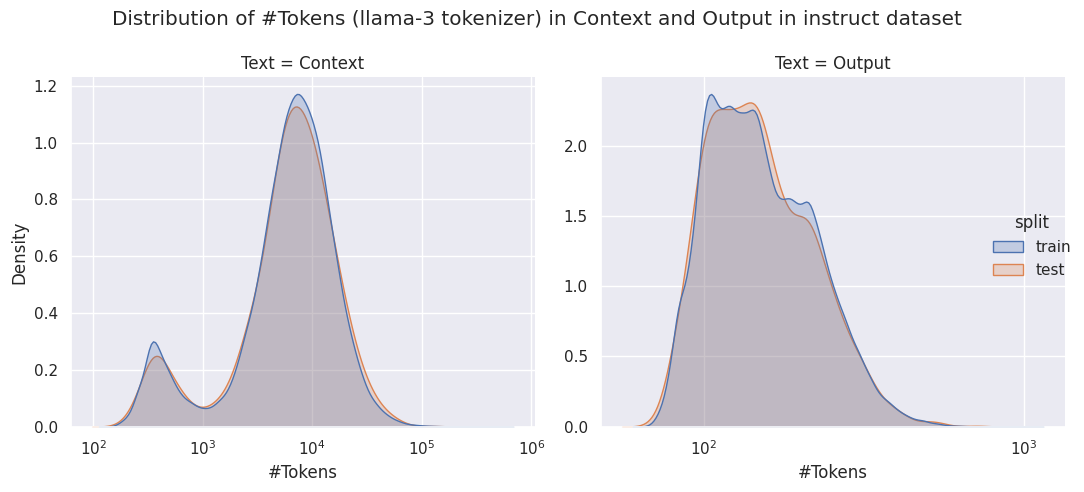

In [16]:
# | eval: false
tok_melt = instruct_ds_tok.melt(id_vars=["split"], value_vars=["context_num_tokens", "output_num_tokens"], var_name="Text", value_name="#Tokens")
tok_melt["Text"] = tok_melt["Text"].map({"context_num_tokens": "Context", "output_num_tokens": "Output"})

g = sns.displot(data=tok_melt, x="#Tokens", col="Text", hue="split", kind="kde", fill=True, log_scale=True, common_norm=False, facet_kws=dict(sharex=False, sharey=False))
g.figure.suptitle("Distribution of #Tokens (llama-3 tokenizer) in Context and Output in instruct dataset")
g.figure.tight_layout()
plt.show()

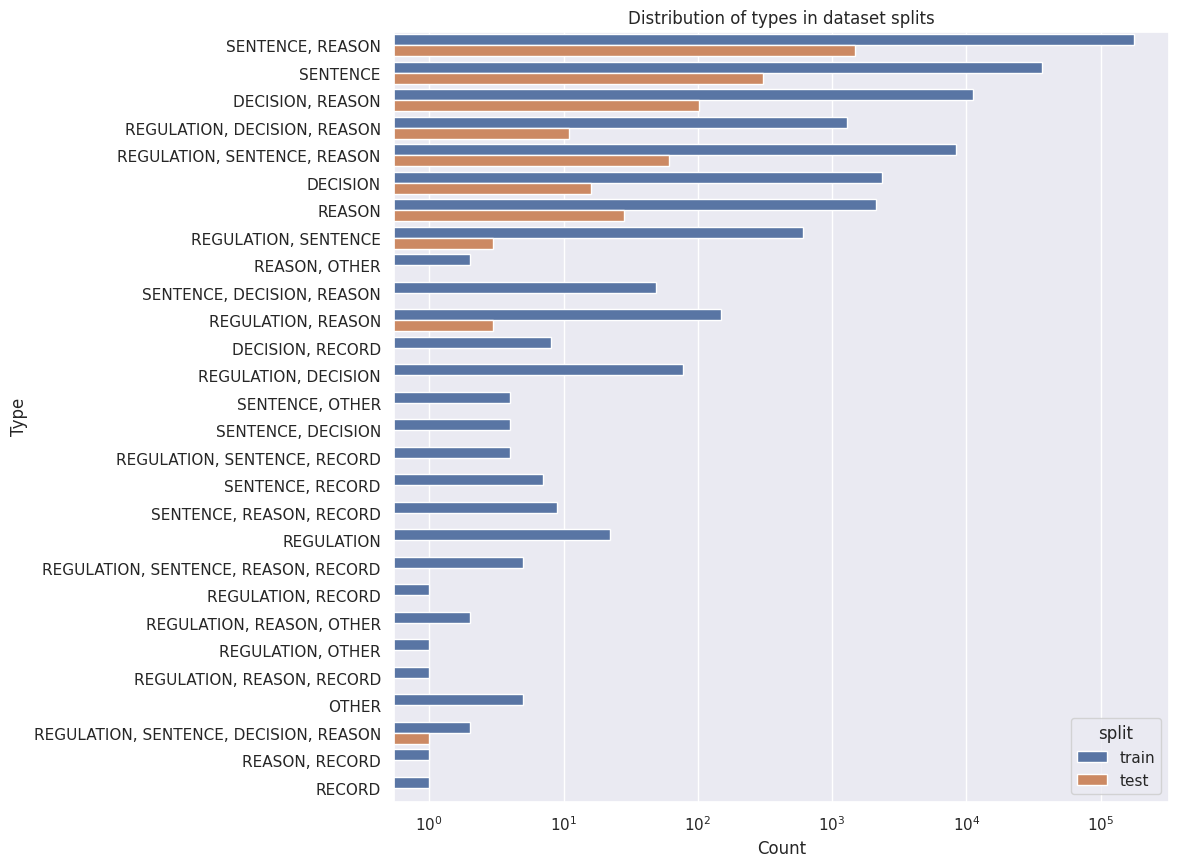

In [17]:
# | eval: false
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.countplot(data=per_type_tokens.join(instruct_ds_tok.set_index("_id"), how="right"), y="type", hue="split")
ax.set(xscale="log", title="Distribution of types in dataset splits", xlabel="Count", ylabel="Type")
plt.show()